### Training data preparation for UNET segmentation model

Pre-requisites:
- ensure you have download the DICOM data (download_data_lidc.ipynb)

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 2.0 MB 21.8 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 20.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 57.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 59.2 MB/s eta 0:00:01
     |████████████████████████████████| 203 kB 56.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 69.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 73.1 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 8.4 MB/s  eta 0:00:01
     |████████████████████████████████| 135 kB 53.6 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 6.0 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 3.6 MB/s  eta 0:00:01
     |████████████████████████████████| 4.0 MB 53.5 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 4.4 MB/s  eta 0:00:01
     |████████████████████████████████| 95 kB 4.9 MB/s  eta 0:00:01
     |████████████████████████████████|

In [2]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import contextlib
import matplotlib.patches as patches
import os
import imageio
import sys
from glob import glob
import os
import cv2
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import os
from numpy import random
import time
import pandas as pd
from PIL import Image
import contextlib
import os
import contextlib
import imageio
from __future__ import print_function
import sys
from contextlib import redirect_stdout, redirect_stderr
import cv2
from pathlib import Path
import random
import math

Following the data preprocessing approach from this paper 

https://www-sciencedirect-com.libproxy.berkeley.edu/science/article/pii/S003040261831235X

In [3]:
class RedirectStdStreams(object):
    def __init__(self, stdout=None, stderr=None):
        self._stdout = stdout or sys.stdout
        self._stderr = stderr or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

### Data pre-processing

The DICOM image for each patient has multiple slices. Each patient may have one or more nodules.

- We will select a 64x64 cropped image with the nodule at the center for each slice which has the nodule annotated
- We will also select one negative image, i.e. a slice which has no annotated nodule around the same slice region as the nodule
- We also use only those nodules that have annotations from all 4 radiologists


##### Preprocessing steps:
- Mark the mask for nodules which were annotated by all 4 radiologists
- Select all the slices which have annotated masks
- Select an equal number of slices which have no annotated masks (for negative images)
- Create the bounding box label for each slice with a mask using find coutours method

In [4]:
def set_dicom_path(dicom_path):
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_path +'\n')
    f.write('warn = True')
    f.close()

In [5]:
import matplotlib.patches as patches
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
        
    if len(minx) > 0:
        return [(a, b, w-a, h-b) for a, b, w, h in zip(minx, miny, maxx, maxy)]
    else:
        return None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    boxes = get_bounding_box(img)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

In [6]:
def find_all_bboxes(nodule_annotation, nodule_id, plot=False):
    bboxes = []
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient {} is {}".format(patient_id, nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        

    print("There are {} slices in the image".format(cbbox_CT[nodule_id][2].stop - cbbox_CT[nodule_id][2].start))
    for idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        boxes = get_bounding_box(CT_mask[:,:,idx])
        if plot:
            plot_bounding_box(CT_mask[:,:,idx])
        bboxes.append(boxes)
    return bboxes

In [7]:
def plot_bbox_on_full_size_mask(vol, nodules_annotation, nodule_id):
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient is {}".format(nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        
    for slice_idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        plot_bounding_box(CT_mask[:,:,slice_idx])

In [8]:
def plot_bbox_on_image(vol, nodules_annotation, nodule_id):
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient is {}".format(nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        
    for slice_idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        boxes = get_bounding_box(CT_mask[:,:,slice_idx])
        img = vol[:,:,slice_idx]
        fig, ax = plt.subplots()
        ax.imshow(img, cmap=plt.cm.gray)
        if boxes:
            for box in boxes:
                x, y, w, h = box
                print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

In [9]:
import shutil
def clear_dirs(paths):
    for path in paths:
        if os.path.isdir(path):
            shutil.rmtree(path)

In [10]:
def un(a, b):
    return np.union1d(a, b)

def unr(ll, acc, i):
    if i < len(ll):
        j = i + 1
        acc = un(ll[i], acc)
        return unr(ll, acc, j)
    else:
        return acc

def get_slices_with_masks(cbbox_CT):
    ll = []
    for cb in cbbox_CT:
        ll.append(np.arange(cb[2].start, cb[2].stop+1))
    return unr(ll, [], 0)

In [11]:
def load_patient_vol_and_mask(dicom_dir, patient_id=-1):
    
    devnull = open(os.devnull, 'w')
    
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_dir +'\n')
    f.write('warn = True')
    f.close()
    
    patient_list = os.listdir(dicom_dir)
    if patient_id == -1: #select one randomly
        patient_id = np.random.choice(patient_list)
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    vol = None
    try:
        with RedirectStdStreams(stdout=devnull, stderr=devnull):
            vol = scan.to_volume()
    except:
        print("Error loading DICOM for patient {}".format(patient_id))
        return None, None, None, None
    # are there nodules that are useful?

    # process the mask for the image
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        if len(nodule) >= 2:
            cmask, cbbox, masks = consensus(nodule)
            cmask_CT.append(cmask)
            cbbox_CT.append(cbbox)
            masks_CT.append(masks)

    if len(cbbox_CT) <=0:
        #print("No relevant nodules for patient {}".format(patient_id))
        return None, None, None, None


    # create the mask voxel
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    #print("Number of nodules {}".format(nodule_num))
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask

    # get the slices that have annotations
    slices_with_mask = get_slices_with_masks(cbbox_CT)
    
    return vol, CT_mask, cbbox_CT, slices_with_mask

In [12]:
def plot_side_by_side(vol, mask, idx):
    f, a = plt.subplots(1,2, figsize=(8,10))
    a[0].imshow(vol[:,:,idx])
    a[1].imshow(mask[:,:,idx])
    plt.show()

# get 8 pixels along all axes
def plot_side_by_side_cropped(cbbox, vol, mask, idx):
    f, a = plt.subplots(1,2, figsize=(8,10))
    a[0].imshow(vol[cbbox[0],cbbox[1],cbbox[2]][:,:,idx])
    a[1].imshow(mask[cbbox[0],cbbox[1],cbbox[2]][:,:,idx])
    plt.show()

### UNET data augmentation

- We process the image to highlight the region of interest
- During training we also randomly choose to use a imgae-in-painting technique to add variation to the data


#### Generate data for Unet

- Select patients from the dicom dir
- for each patient, load the volumes and masks
    - Choose only those nodules that are annotated by more than 4 radiologists
    - Select only those slices from the DICOM image which has annotated masks
    - For each of those slices, extract a cropped 64x64 image around the mask with the annotated bounding box in the center
    - Also generate at least one 64x64 image with the center randomly chosen in the annotated bounding box

In [13]:
# take 32 pixels including c_x on each axis
def get_stride(c, size=32):
    start = 0
    if (c - size) > 0:
        start = c - size
    else:
        start = 0
    if (c + size) < 512:
        stop = c + size
    else:
        stop = size
    return slice(start, stop, None)

"""
    Get a 64x64 image around the nodule, when using random = false, we get the actual clip of the annotated nodule,
    when using random = true, get a 64x64 image around the nodule randomly chosen which may or may not show a part of the nodule
"""
def get_nodule_part(cbbox, random=False, shape=(32, 32), num_images=1):
    pct_shift = 0.3
    # extract 64x64 size images from the image randomly including the mask
    c_xs = [int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)]
    c_ys = [int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)]
    #print(c_x, c_y)
    if random: # random center within 64x64 box
#         c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
#         c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
        center_x = cbbox[0].start + int((cbbox[0].stop - cbbox[0].start)/2)
        center_y = cbbox[1].start + int((cbbox[1].stop - cbbox[1].start)/2)
        # 10% of the image width is the jitter boundary
        c_xs = np.random.choice(np.arange(center_x-int(shape[0]*pct_shift), center_x+int(shape[0]*pct_shift)), num_images, replace=False)
        c_ys = np.random.choice(np.arange(center_y-int(shape[1]*pct_shift), center_y+int(shape[1]*pct_shift)), num_images, replace=False)
    return [(get_stride(c_x, shape[0]), get_stride(c_y, shape[1]), cbbox[2]) for c_x, c_y in zip(c_xs, c_ys)]

"""
    Get a 64x64 image just outside the nodule bounding box 
"""
def get_outside_part(cbbox, random=False):
    # extract 64x64 size images from the image randomly including the mask
    c_x = int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)
    c_y = int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)
    #print(c_x, c_y)
    if random: # random center within 64x64 box
        c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
        c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
    return get_stride(c_x, shape[0]), get_stride(c_y, shape[0]), cbbox[2]

#### Routine to extract the region of interest (ROI) in the image

In [14]:
#code ref: https://github.com/JenifferWuUCLA/pulmonary-nodules-segmentation/blob/master/tianchi_segment_lung_ROI.ipynb
def preprocess_image(img):
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    #　to renormalize washed out images
    #middle = img[100:400, 100:400]
    middle = img
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the
    #　underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    # Using Kmeans to separate foreground (radio-opaque tissue)
    #　and background (radio transparent tissue ie lungs)
    # Doing this only on the center of the image to avoid
    #　the non-tissue parts of the image as much as possible
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold, 1.0, 0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img, np.ones([4, 4]))
    dilation = morphology.dilation(eroded, np.ones([10, 10]))
    labels = measure.label(dilation)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
            good_labels.append(prop.label)

    mask = np.zeros_like(labels)
    for N in good_labels:
        mask = mask + np.where(labels == N, 1, 0)

    mask = morphology.dilation(mask, np.ones([10, 10]))  # one last dilation
    return img * mask

In [34]:
"""
    Select one negative sample, crops the same x, y slice from the volume on another z index that has no masks
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
    size = the size of the cropped image to return
"""
def select_another_slice(vol, slcz):
    idxs_after = np.arange(slcz.stop + 1, vol.shape[2])
    idxs_before = np.arange(0, slcz.start - 1)
    slices = []
    if len(idxs_after) > 10: # at least 10 more slices after the stop of the annotation box
        r = np.random.choice([2,3,4])
        slices.append(idxs_after[r])
    if len(idxs_before) > 10:
        sz = len(idxs_before)
        r = np.random.choice([sz-2,sz-3,sz-4])
        slices.append(idxs_before[r])
    if len(slices) <=0: # if this was towards the edge of the voxel
        slices.append(slcz.start)
    choice = np.random.choice(slices)
    return choice
def get_bounding_box_from_slice(s):
    x, y, z = s
    cx = int(x.start + (x.stop - x.start)/2)
    cy = int(y.start + (y.stop - y.start)/2)
    w = (x.stop - x.start)
    h = (y.stop - y.start)
    return (cx, cy, w, h)

def get_crops(boxes):
    crops = []
    if boxes:
        for box in boxes:
            x, y, w, h = box
            cx = int(x + w/2)
            cy = int(y + h/2)
            crops.append((get_stride(cx), get_stride(cy)))
    return crops

"""
    Get one negative sample for this patient per nodule
"""
def save_negative_sample(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, 
                            image_save=False, image_plot=True, size=(64,64)):
    devnull = open(os.devnull, 'w')
    assert os.path.exists('/app/data/unet/temp/')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
        
    
    slcz = bounding_box[nodule_number][2]
    selected_slice = select_another_slice(vol, slcz)
    box = get_bounding_box_from_slice(bounding_box[nodule_number])
    
    #the functions works on an arrays, get a 64x64 cropped image
    crops = get_crops([box])
    if len(crops) < 1:
        return
    crop = crops[0]
    
    fullimg = vol[:,:,selected_slice]
    #save and reload
    try:
        with RedirectStdStreams(stdout=devnull, stderr=devnull):    
            imageio.imwrite('/app/data/unet/temp/temp_img.jpg', fullimg)
            disk_img = cv2.imread('/app/data/unet/temp/temp_img.jpg')
    except:
        print("Error saving intermediate image for patient {}".format(patient_id))
        return
    im = cv2.cvtColor(disk_img, cv2.COLOR_BGR2GRAY)
    img_t = preprocess_image(im)
    cropped_img = img_t[crop[0],crop[1]]
    mask = CT_mask[crop[0],crop[1],selected_slice]
    
    #img = vol[crop[0],crop[1],selected_slice]
    
    if cropped_img.shape != (size[0], size[1]):
        print("Incorrect cropped image size", cropped_img.shape)
        return
    if mask.shape != (size[0], size[1]):
        print("Incorrect mask size", mask.shape)
        return
    if len(np.unique(mask)) > 1:
        print("Negative sample but mask length {} is > 1, not saving.".format(len(np.unique(mask))))
        return
    
    if image_save:
        image_file_name = "img_out_{}_{}_{}.jpg".format(patient_id, nodule_number, selected_slice)
        mask_file_name = "mask_out_{}_{}_{}.jpg".format(patient_id, nodule_number, selected_slice)
        with RedirectStdStreams(stdout=devnull, stderr=devnull):
            imageio.imwrite(image_dir + image_file_name, cropped_img)
        with RedirectStdStreams(stdout=devnull, stderr=devnull):    
            imageio.imwrite(mask_dir + mask_file_name, mask)
    if image_plot:
        f, a =  plt.subplots(1,2, figsize=(8,10))
        a[0].imshow(cropped_img, 'bone')
        a[0].set_title("img_out_{}_{}_{}.jpg".format(patient_id, nodule_number, selected_slice))
        a[1].imshow(mask, 'bone')
        plt.show()

In [27]:
"""
    Save the nodule image and at least one more random image with the nodule visible but not identical to the nodule image
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
"""
def save_image_foreach_slice(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, image_save=False, image_plot=True, size=(64, 64), num_images=1):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    # Get the clip such that the nodule is at the center of the 64x64 image
    slcs = get_nodule_part(bounding_box[nodule_number], random, shape=(int(size[0]/2), int(size[1]/2)), num_images=num_images)
    cnt = 0
    for slc in slcs:
        assert len(unique_slice_ids) == len(range(slc[2].stop - slc[2].start))
        for slice_index, unique_slice_id in zip(range(slc[2].stop - slc[2].start),unique_slice_ids):
            fullimg = vol[:,:,slc[2]][:,:,slice_index]
            vol_t = preprocess_image(fullimg)
            img = vol_t[slc[0],slc[1]]
            mask = CT_mask[slc[0],slc[1],slc[2]][:,:,slice_index]
            if img.shape != (size[0], size[1]):
                print("Error: image size is not {}".format(size))
                continue
            if mask.shape != (size[0], size[1]):
                print("Error: mask size is not {}".format(size))
                continue
            if image_save:
                if random:
                    image_file_name = "img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                    mask_file_name = "mask_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                else:
                    image_file_name = "img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                    mask_file_name = "mask_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(image_dir + image_file_name, img)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(mask_dir + mask_file_name, mask)
            if image_plot:
                cnt += 1
                f, a =  plt.subplots(1,2, figsize=(10,16))
                a[0].imshow(img, 'bone')
                if random:
                    a[0].set_title("img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
                else:
                    a[0].set_title("img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
                a[1].imshow(mask, 'bone')
                plt.show()
    if image_plot:
        print("Saved {} images".format(cnt))

#### Test the image generation code

There are 1 nodules


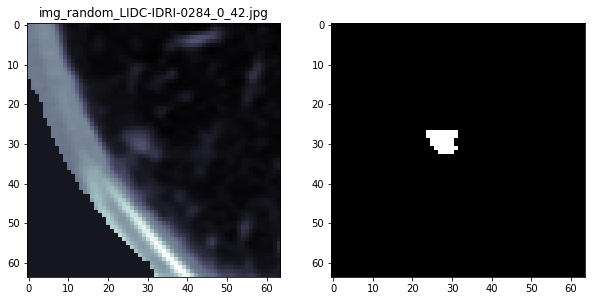

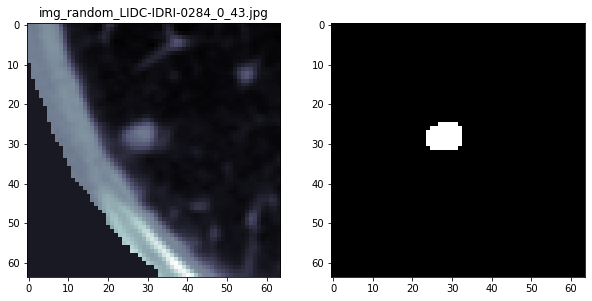

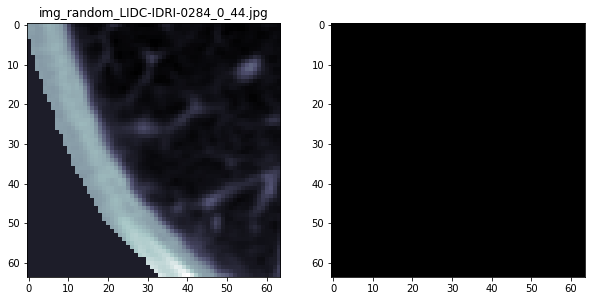

Saved 3 images


In [28]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/app/data/lidc/dicom/train/sorted_gcsfiles', 'LIDC-IDRI-0040')
print("There are {} nodules".format(len(cbbox)))
for nodule_num in range(len(cbbox)):
    save_image_foreach_slice(root_dir='/app/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=nodule_num,  
                             vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True, size=(64,64), num_images=1)

There are 1 nodules


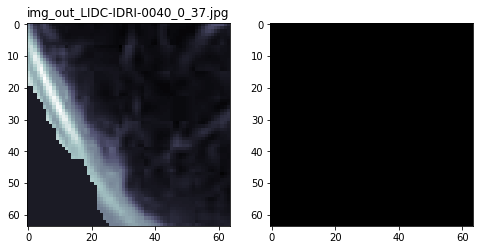

In [29]:
root_dir= '/app/data/unet/train/'
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/app/data/lidc/dicom/train/sorted_gcsfiles', 'LIDC-IDRI-0040')
print("There are {} nodules".format(len(cbbox)))
for nodule_num in range(len(cbbox)):
    save_negative_sample(root_dir=root_dir, patient_id='LIDC-IDRI-0040', bounding_box=cbbox, nodule_number=nodule_num,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True, size=(64,64))

In [31]:
def save_generated_images_for_patient(root_dir='/app/data/unet/train/', dicom_dir='/rawdata/train/sorted_gcsfiles', patient_id='LIDC-IDRI-0284'):
    vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir, patient_id)
    if cbbox:
        for nodule_num in range(len(cbbox)):
            # One positive image (image containing a visible nodule) per slice per nodule
            save_image_foreach_slice(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=nodule_num,  
                             vol=vol, CT_mask=CT_mask, random=False, image_save=True, image_plot=False, size=(64,64), num_images=1)
            # One negative image per nodule
            save_negative_sample(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=nodule_num,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=False, size=(64,64))

In [32]:
import os
root_path = '/app/data/unet/train/'
"""
    UNET data dir should have only 'images' and 'masks' folder and they should be empty
"""
def check_dirs(root_path):
    if not os.path.exists('/app/data/unet/temp/'):
        os.makedirs('/app/data/unet/temp/')
    if not os.path.exists(root_path):
        #create
        imagedir = root_path + "/images/"
        maskdir = root_path + "/masks/"
        os.makedirs(imagedir)
        os.makedirs(maskdir)
    dirs = os.listdir(root_path)
    s = np.setdiff1d(np.array(['images', 'masks']), np.array(dirs))
    assert len(s) == 0, "Directory structure not correct!"
    for d in dirs:
        tmp = root_path + "/" + d
        if os.path.exists(tmp):
            files = os.listdir(tmp)
            assert len(files) <= 0, "Directory not empty!"

In [33]:
%%time
patients = os.listdir('/app/data/lidc/dicom/train/sorted_gcsfiles/')
data_dir = '/app/data/unet/train/'
check_dirs(data_dir)
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir=data_dir, dicom_dir='/app/data/lidc/dicom/train/sorted_gcsfiles/', patient_id=pat)

 73%|███████▎  | 37/51 [04:44<01:52,  8.05s/it]

Mask length 2


 92%|█████████▏| 47/51 [06:21<00:31,  7.94s/it]

Mask length 2


100%|██████████| 51/51 [07:02<00:00,  8.29s/it]

CPU times: user 10min 31s, sys: 46.2 s, total: 11min 17s
Wall time: 7min 2s


In [35]:
%%time
patients = os.listdir('/app/data/lidc/dicom/val/sorted_gcsfiles/')
data_dir = '/app/data/unet/val/'
check_dirs(data_dir)
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir=data_dir, dicom_dir='/app/data/lidc/dicom/val/sorted_gcsfiles/', patient_id=pat)

  4%|▍         | 6/151 [00:29<11:17,  4.67s/it]

Negative sample but mask length 2 is > 1, not saving.


 13%|█▎        | 19/151 [02:13<17:16,  7.86s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 35%|███▌      | 53/151 [07:10<17:07, 10.48s/it]

Negative sample but mask length 2 is > 1, not saving.


 57%|█████▋    | 86/151 [10:57<06:55,  6.40s/it]

Negative sample but mask length 2 is > 1, not saving.


 63%|██████▎   | 95/151 [12:59<09:04,  9.72s/it]

Negative sample but mask length 2 is > 1, not saving.


 72%|███████▏  | 108/151 [13:54<02:01,  2.84s/it]

Error loading DICOM for patient LIDC-IDRI-0332


 84%|████████▍ | 127/151 [16:49<03:44,  9.36s/it]

Negative sample but mask length 2 is > 1, not saving.


100%|██████████| 151/151 [20:40<00:00,  8.21s/it]

CPU times: user 29min 37s, sys: 2min 19s, total: 31min 56s
Wall time: 20min 40s


In [36]:
%%time
patients = os.listdir('/app/data/lidc/dicom/test/sorted_gcsfiles/')
data_dir = '/app/data/unet/test/'
check_dirs(data_dir)
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir=data_dir, dicom_dir='/app/data/lidc/dicom/test/sorted_gcsfiles/', patient_id=pat)

100%|██████████| 48/48 [07:57<00:00,  9.95s/it]

CPU times: user 12min 1s, sys: 50.9 s, total: 12min 52s
Wall time: 7min 57s


### EDA on generated data

In [40]:
root_dir = '/app/data/unet/'
split_type = 'train'
imagefiles = os.listdir(root_dir + '/' + split_type + '/images/')
maskfiles = os.listdir(root_dir + '/' + split_type + '/masks/')
print("Number of samples in {} is data: {}, label: {}".format(split_type, len(imagefiles), len(maskfiles)))

Number of samples in train is data: 581, label: 581


In [41]:
negative_cnt = [imagefile for imagefile in imagefiles if imagefile.find('_out') > 0]
positive_cnt = [imagefile for imagefile in imagefiles if imagefile.find('_out') <= 0]
print("Number of postive samples = {} and negative samples = {}".format(len(positive_cnt), len(negative_cnt)))

Number of postive samples = 493 and negative samples = 88


#### Review the transformed image

Text(0.5, 1.0, 'Processed image')

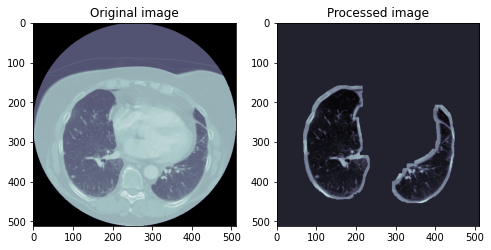

In [42]:
img = vol[:,:,int(np.random.choice(slices_with_mask))]
img_t = preprocess_image(img)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img, 'bone')
ax1.set_title('Original image')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(img_t, 'bone')
ax2.set_title('Processed image')

In [93]:
maskinfiles = [maskfile for maskfile in maskfiles if maskfile.find('_out') <= 0]
widths = []
heights = []
cnt = 0
for maskfile in tqdm(maskinfiles):
    mask = cv2.imread(root_dir + 'train/masks/' + maskfile)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    boxes = get_bounding_box(mask)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            widths.append(int(w))
            heights.append(int(h))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4132/4132 [00:02<00:00, 1542.18it/s]


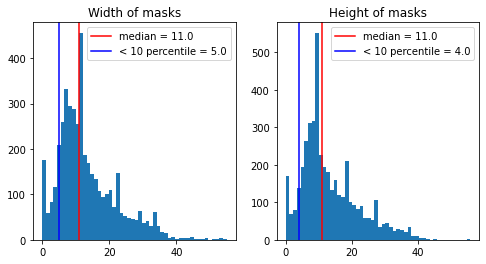

In [135]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(widths, bins=50)
ax1.set_title('Width of masks')
ax1.axvline(x=np.median(widths), color='r', label='median = {}'.format(np.median(widths)), c='r')
ax1.axvline(x=np.quantile(widths, [0.1])[0], color='b', label='< 10 percentile = {}'.format(np.quantile(widths, [0.1])[0]), c='b')
plt.legend()
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(heights, bins=50)
ax2.set_title('Height of masks')
ax2.axvline(x=np.median(heights), color='r', label='median = {}'.format(np.median(heights)), c='r')
ax2.axvline(x=np.quantile(heights, [0.1])[0], color='b', label='< 10 percentile = {}'.format(np.quantile(heights, [0.1])[0]), c='b')
plt.legend()

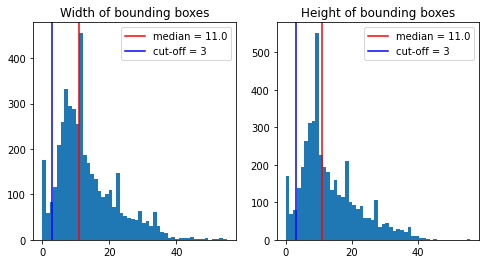

In [152]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(widths, bins=50)
ax1.set_title('Width of bounding boxes')
ax1.axvline(x=np.median(widths), color='r', label='median = {}'.format(np.median(widths)), c='r')
ax1.axvline(x=3, color='b', label='cut-off = {}'.format(3), c='b')
plt.legend()
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(heights, bins=50)
ax2.set_title('Height of bounding boxes')
ax2.axvline(x=np.median(heights), color='r', label='median = {}'.format(np.median(heights)), c='r')
ax2.axvline(x=3, color='b', label='cut-off = {}'.format(3), c='b')
plt.legend()